In [1]:
!sudo apt update && sudo apt install -y graphviz
!pip install graphviz

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1,135 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [796 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [581 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [30.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1,275 kB]    
Get:10 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:11 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [14]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List, Dict
from contextlib import contextmanager
from queue import Queue
from dataclasses import dataclass, field
from collections import defaultdict
import random
import time
import math


import numpy as np
from matplotlib import pyplot as plt
from graphviz import Digraph

random.seed(0)
%matplotlib inline

In [15]:
class Neuron(ABC):
    """
    An abstract definition for a Neuron. A neuron has inputs and outputs,
    which are in turn also Neurons. Together they form a "Neural Network".
    """
    
    def __init__(self, name: str = "no name"):
        self.name = name
        self._inputs: List[Neuron] = list()
        self._outputs: List[Neuron] = list()
    
    @property
    def inputs(self):
        return self._inputs
    
    def reset(self):
        ...
    
    @property
    def outputs(self):
        return self._outputs
    
    def add_input(self, n: Neuron):
        self._inputs.append(n)
        
    def add_output(self, n: Neuron):
        self._outputs.append(n)
    
    @abstractmethod
    def forward_pass(self, state: ForwardPassState) -> float:
        ...
        
    @abstractmethod
    def backwards_pass(self, state: BackwardsPassState, f_state: ForwardPassState) -> None:
        ...
        
    def __rshift__(self, other: Neuron) -> Neuron:
        other.add_input(self)
        self.add_output(other)
    
    def __repr__(self):
        return self.name
    

In [16]:
class Loss(ABC):
    """
    Interface for an error function. The error is the measure of how wrong we are,
    the loss is the direction (and magnitude) in which we should move to correct our current model;.
    """
    
    def __init__(self, name: str):
        self.name = name
    
    @abstractmethod
    def error(self, predicted: float, actual: float) -> float:
        ...
            
    @abstractmethod
    def loss(self, predicted: float, actual: float) -> float:
        ...
        
    def __repr__(self) -> str:
        return self.name
    

class SquaredLoss(Loss):
    def __init__(self):
        super().__init__("squared_loss")
        
    def error(self, predicted: float, actual: float) -> float:

        # Squared error (SE) defined as: E = (y-y')^2
        return (actual-predicted)**2
            
    def loss(self, predicted: float, actual: float) -> float:
        # Derivative of E with respect to predicted
        # E = (y-y')^2
        # DE/Dy' = -2(y-y')
        return -2*(actual - predicted)

In [17]:
class Input(Neuron):
    """
    Mostly useless Neuron that just holds the input data   
    """
    def __init__(self):
        super().__init__("input")
        
    def forward_pass(self, state: ForwardPassState) -> float:
        return state.activations[self]
        
    def backwards_pass(self, state: BackwardsPassState, f_state: ForwardPassState) -> None:
        ...
    

class HiddenLayer(Neuron):
    """
    This is the important part of the puzzle, this is our linear classifier.
    It learns a linear function y = Wx + b
    y's are stored in self._weights, and b's are stored in self._biases
    
    There are multiple weights and biases in case this Neuron has multiple inputs.
    """
    def __init__(self, name: str):
        super().__init__(name)
        self._weights: Dict[Neuron, float] = dict()
        self._biases: Dict[Neuron, float] = dict()
        
    def add_input(self, n: Neuron):
        super().add_input(n)
        self._weights[n] = None
        self._biases[n] = 0.
        self.initialize_weights()
        
    def reset(self):
        self.initialize_weights()
        
    def initialize_weights(self):
        """
        There are many strategies for intializing weights randomly, mostly black magic.
        Lots of resources on this online, look for "weight initialization in deep learning"
        """
        std = math.sqrt(2.0 / len(self._weights))
        for k in self._weights.keys():
            self._weights[k] = np.random.randn() * std
        
    def forward_pass(self, state: ForwardPassState) -> float:
        """
        The forward pass is essentially our current belief of the world, 
        given an input this function predicts an output based on the current knowledge (weights and biases).
        So in effect this just runs y = Wx + b.
        
        The input values to this neuron are stored in state.activations, so those are the inputs
        """
        return np.sum([
            state.activations[i] * self._weights[i] + self._biases[i]
            for i in self._inputs
        ])
        
    def backwards_pass(self, state: BackwardsPassState, f_state: ForwardPassState) -> None:
        incomming_loss = state.losses[self]
        
        # send loss back to incoming connections
        for i in self.inputs:
             
            # backpropagate to inputs
            state.losses[i] = self._weights[i] * incomming_loss
            
            
            # backpropagate to weights
            # here we update the weights based on the "loss" we are receiving from upstream neurons.
            # We multiply the current inputs (activations) by the loss because of the derivative of our function:
            
            # y = Wx + b
            # Dy/Dw = x
            # so we scale the loss by x
            
            self._weights[i] -= state.learning_rate * (f_state.activations[i] * incomming_loss + state.regularization * self._weights[i])
            
            
            # backpropagate to biases
            # here, we take the derivative with respect to the bias
            # Dy/Db = 1, so we scale by 1 (don't need to write code for that)
            self._biases[i] -= state.learning_rate * incomming_loss     

In [18]:
@dataclass
class ForwardPassState:
    activations: Dict[Neuron, float] = field(default_factory=dict)
          
                  
@dataclass
class BackwardPassState:
    learning_rate: float
    regularization: float
    losses: Dict[Neuron, float] = field(default_factory=dict)

In [19]:
class Normalizer:
    """
    Making sure data is normalized in a 0-1 range is helpful for neural nets to converge during learning
    """
    
    def __init__(self):
        self.maximum = None
    
    def learn(self, values):
        self.maximum = np.max(values)

    def to_norm(self, values):
        return np.divide(values, self.maximum)
    
    def from_norm(self, values):
        return np.multiply(values, self.maximum)

In [20]:
@dataclass
class Model:
    """
    Model class brings it all together by implementing the main learning loop
    """
    
    input_layer: Neuron
    output_layer: Neuron
    loss: Loss
    
    @staticmethod
    def breadth_first_search(root: Neuron):
        """
        Breadth first search is useful for processing the neurons in the right order layer-by-layer
        """
        processed = set()
        queue = Queue()
        queue.put(root)
        while not queue.empty():
            item: Neuron = queue.get()
            for output in item.outputs:
                queue.put(output)
            if item not in processed:
                yield item
            processed.add(item)
    
    def reset(self):
        for node in self.breadth_first_search(self.input_layer):
            node.reset()
    
    def avg_error(self, xs, ys):
        errors = []
        for i in range(0, len(xs)):
            f_state = self.run_forward_pass(self.input_layer, xs[i])
            error = self.loss.error(f_state.activations[self.output_layer], ys[i])
            errors.append(error)
        return np.mean(errors)
            
    def predict(self, xs):
        results = []
        for x in xs:
            f_state = self.run_forward_pass(self.input_layer, x)
            results.append(f_state.activations[self.output_layer])
        return results
    
    def run_forward_pass(self, i: Input, x: float) -> Dict:
        """
        Step 1 of learning, apply our belief to the input
        """
        state = ForwardPassState()
        state.activations[i] = x
        for node in self.breadth_first_search(i):
            output = node.forward_pass(state)
            state.activations[node] = output
        return state

    def run_backward_pass(self, i: Input, loss: Neuron, forward_state: ForwardPassState, learning_rate: float, regularization: float):
        """
        Step 3 of learning, backpropagate the loss to all the neurons and update their beliefs
        """
        state = BackwardPassState(learning_rate=learning_rate, regularization=regularization)
        nodes = list(reversed(list(self.breadth_first_search(i))))
        state.losses[nodes[0]] = loss
        for node in nodes:
            node.backwards_pass(state, forward_state)
        return state
    
    def learn(self, xs, ys, iterations=1000, learning_rate=.001, regularization=0.01):
        """
        The main learning loop, this is where all the magic happens :)
        """
        nodes = list(self.breadth_first_search(self.input_layer))
        for i in range(0, iterations):
            data_index = i % len(xs)
            x = xs[data_index]
            y = ys[data_index]

            f_state = self.run_forward_pass(self.input_layer, x)
            loss = self.loss.loss(f_state.activations[self.output_layer], y)
            b_state = self.run_backward_pass(self.input_layer, loss, f_state, learning_rate=learning_rate, regularization=regularization)
            
    def dot(self):
        dot = Digraph()
        for node in reversed(list(self.breadth_first_search(i))):
            dot.node(name=str(node), label=str(node))
            for output in node.outputs:
                dot.edge(str(node), str(output))
        return dot
            

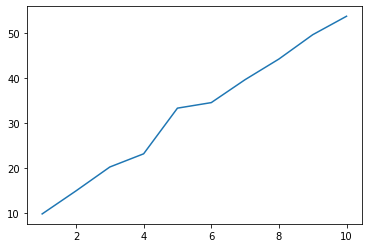

In [21]:
xs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ys = [5*i + 5 for i in xs] + np.random.normal(0, 2, xs.shape)
plt.plot(xs, ys)
plt.show()


x_norm = Normalizer()
x_norm.learn(xs)
y_norm = Normalizer()
y_norm.learn(ys)

n_xs = x_norm.to_norm(xs)
n_ys = y_norm.to_norm(ys)

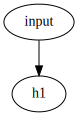

In [22]:
# Simple Linear Examples (1 Neuron)

i = Input()
h1 = HiddenLayer("h1")
i >> h1

loss = SquaredLoss()

m = Model(i, h1, loss)
m.dot()

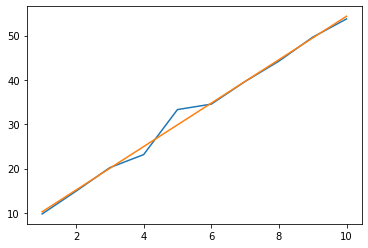

{input: 0.9113465354706737}
{input: 0.099935823156353}


In [23]:
m.reset()
m.learn(n_xs, n_ys, iterations=10000, learning_rate=.01, regularization=0.0001)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)
plt.plot(xs, predictions)
plt.show()

print(h1._weights)
print(h1._biases)

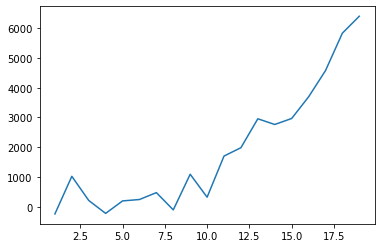

In [24]:
xs = np.array(list(range(1, 20)))
ys = [i**3 + 5 for i in xs] + np.random.normal(0, 500, xs.shape)
plt.plot(xs, ys)
plt.show()

x_norm = Normalizer()
x_norm.learn(xs)
y_norm = Normalizer()
y_norm.learn(ys)

n_xs = x_norm.to_norm(xs)
n_ys = y_norm.to_norm(ys)

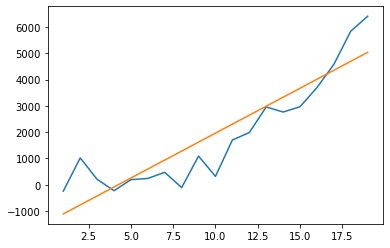

In [25]:
m.reset()
m.learn(n_xs, n_ys, iterations=10000, learning_rate=.01, regularization=0.0001)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)
plt.plot(xs, predictions)
plt.show()

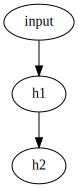

In [26]:
# Simple Linear Examples (2 Neuron)

i = Input()
h1 = HiddenLayer("h1")
h2 = HiddenLayer("h2")
loss = SquaredLoss()

i >> h1
h1 >> h2

m = Model(i, h2, loss)
m.dot()

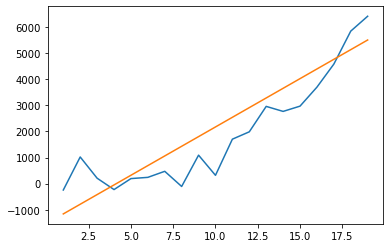

In [27]:
m.reset()
m.learn(n_xs, n_ys, iterations=10000, learning_rate=.01, regularization=0.0)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)
plt.plot(xs, predictions)
plt.show()

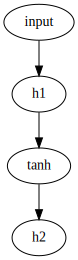

In [28]:
# Simple Linear Examples (2 Neuron + non-linearity)
                        
class TanHLayer(Neuron):
    def __init__(self, name: str = "tanh"):
        super().__init__(name)
        
    def forward_pass(self, state: ForwardPassState) -> float:
        input_val = state.activations[self._inputs[0]]
        return np.tanh(input_val)
            
    def backwards_pass(self, state: BackwardsPassState, f_state: ForwardPassState) -> None:
        incomming_loss = state.losses[self]
        input_val = f_state.activations[self._inputs[0]]
        state.losses[self._inputs[0]] = incomming_loss * (1 - (np.tanh(input_val) ** 2))
        

i = Input()
h1 = HiddenLayer("h1")
a1 = TanHLayer()
h2 = HiddenLayer("h2")
loss = SquaredLoss()

i >> h1
h1 >> a1
a1 >> h2


m = Model(i, h2, loss)
m.dot()

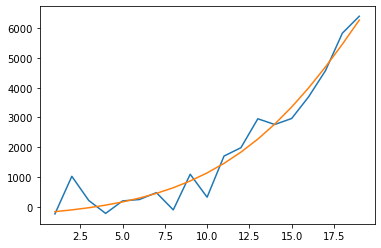

In [29]:
m.reset()
m.learn(n_xs, n_ys, iterations=50000, learning_rate=.01, regularization=0.0)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)
plt.plot(xs, predictions)
plt.show()

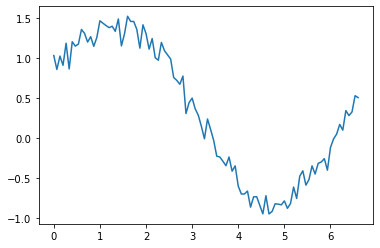

In [30]:
xs = np.array([i/15. for i in range(0, 100)])
ys = [math.sin(i) + 1/(i+1) for i in xs] + np.random.normal(0, .1, xs.shape)
plt.plot(xs, ys)
plt.show()

x_norm = Normalizer()
x_norm.learn(xs)
y_norm = Normalizer()
y_norm.learn(ys)

n_xs = x_norm.to_norm(xs)
n_ys = y_norm.to_norm(ys)

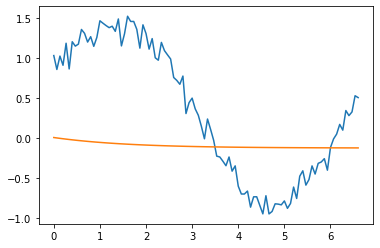

In [31]:
m.reset()
m.learn(n_xs, n_ys, iterations=50000, learning_rate=.01, regularization=0.0)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)

plt.plot(xs, predictions)
plt.show()

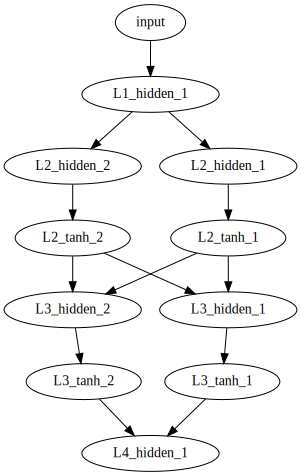

In [32]:
# A more complicated network

            
i = Input()


def create_layer(name: str, neurons: int, activation=True):
    inputs = list()
    outputs = list()
    for n in range(neurons):
        h = HiddenLayer(f"{name}_hidden_{n+1}")
        if activation:
            activation_layer = TanHLayer(f"{name}_tanh_{n+1}")
            h >> activation_layer
            outputs.append(activation_layer)
        else:
            outputs.append(h)
        inputs.append(h)
    return inputs, outputs


def connect(a, b):
    for aa in a:
        for bb in b:
            aa >> bb

            
l1_in, l1_out = create_layer("L1", 1, activation=False)
l2_in, l2_out = create_layer("L2", 2)
l3_in, l3_out = create_layer("L3", 2)
l4_in, l4_out = create_layer("L4", 1, activation=False)

connect([i], l1_in)
connect(l1_out, l2_in)
connect(l2_out, l3_in)
connect(l3_out, l4_in)

loss = SquaredLoss()

m = Model(i, l4_out[0], loss)
m.dot()

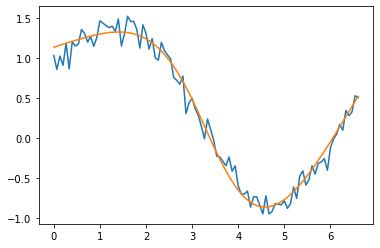

In [33]:
m.reset()
m.learn(n_xs, n_ys, iterations=50000, learning_rate=.01, regularization=0.0)

# plot predictions
predictions = y_norm.from_norm(m.predict(n_xs))
plt.plot(xs, ys)
plt.plot(xs, predictions)
plt.show()